# Hyperparameter Tuning with hyperopt in Python

See http://steventhornton.ca/hyperparameter-tuning-with-hyperopt-in-python for the blog post that complements this notebook. The data used in this notebook comes from the [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial) Kaggle tutorial. You can download the data [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/data).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Load the data
df_train = pd.read_table('labeledTrainData.tsv', sep='\t')
df_test = pd.read_table('testData.tsv', sep='\t')

# Add a column for the score (out of 10)
df_train['score'] = df_train['id'].map(lambda x: int(x.split('_')[1]))
df_test['score'] = df_test['id'].map(lambda x: int(x.split('_')[1]))

# Add a column for the class, 1 for positive, 0 for negative
df_train['class'] = df_train['score'].map(lambda x: int(x > 5))
df_test['class'] = df_test['score'].map(lambda x: int(x > 5))

# Sort the df_test by class (it will need to be sorted later)
df_test = df_test.sort_values('class', ascending=False)

df_train.head()

,id,sentiment,review,score,class
0,5814_8,1,With all this stuff going down at the moment w...,8,1
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",9,1
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,3,0
3,3630_4,0,It must be assumed that those who praised this...,4,0
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,8,1


In [3]:
from nltk.corpus import stopwords
cachedStopWords = stopwords.words('english')

def removeStopwords(s):
    return ' '.join([word for word in s.split() if word not in cachedStopWords])

# Function for cleaning the reviews
def cleanText(s, stopwords):
    s = s.str.lower()                         # Convert to lowercase
    s = s.str.replace(r'<.*?>', ' ')          # Remove HTML characters
    s = s.str.replace('\'', '')               # Remove single quotes ' 
    s = s.str.replace('-', '')                # Remove dashes -
    s = s.str.replace(r'[^a-zA-Z]', ' ')      # Remove non alpha characters
    s = s.map(lambda s: ' '.join(s.split()))  # Remove extra whitespae
    s = s.str.strip()                         # Remove whitespace at start and end
    s = s.apply(lambda x: removeStopwords(x)) # Remove stopwords
    return s

In [4]:
# Clean the reviews
df_train['review'] = cleanText(df_train['review'], cachedStopWords)
df_test['review'] = cleanText(df_test['review'], cachedStopWords)

df_train.head()

,id,sentiment,review,score,class
0,5814_8,1,stuff going moment mj ive started listening mu...,8,1
1,2381_9,1,classic war worlds timothy hines entertaining ...,9,1
2,7759_3,0,film starts manager nicholas bell giving welco...,3,0
3,3630_4,0,must assumed praised film greatest filmed oper...,4,0
4,9495_8,1,superbly trashy wondrously unpretentious explo...,8,1


In [5]:
# Separate into training and test data
X_train = df_train['review']
y_train = df_train['class']
X_test = df_test['review']
y_test = df_test['class']

## The Model

The model consists of 3 parts:

- Construct a matrix of term frequency–inverse document frequency (TF-IDF) features from the corpus of movie reviews
- Select the features with the highest values for the chi-squared statistic from the training data
- Train a linear model using modified-huber loss with stochastic gradient descent (SGD) learning

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection.univariate_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline

# The model
vectorizer = TfidfVectorizer(strip_accents='unicode')
kbest = SelectPercentile(chi2)
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet')

pipe = Pipeline([('vec', vectorizer),
                 ('kbest', kbest),
                 ('clf', clf)])

Fit the model with the default hyperparamter values an plot the ROC curve.

Test AUC = 0.9524


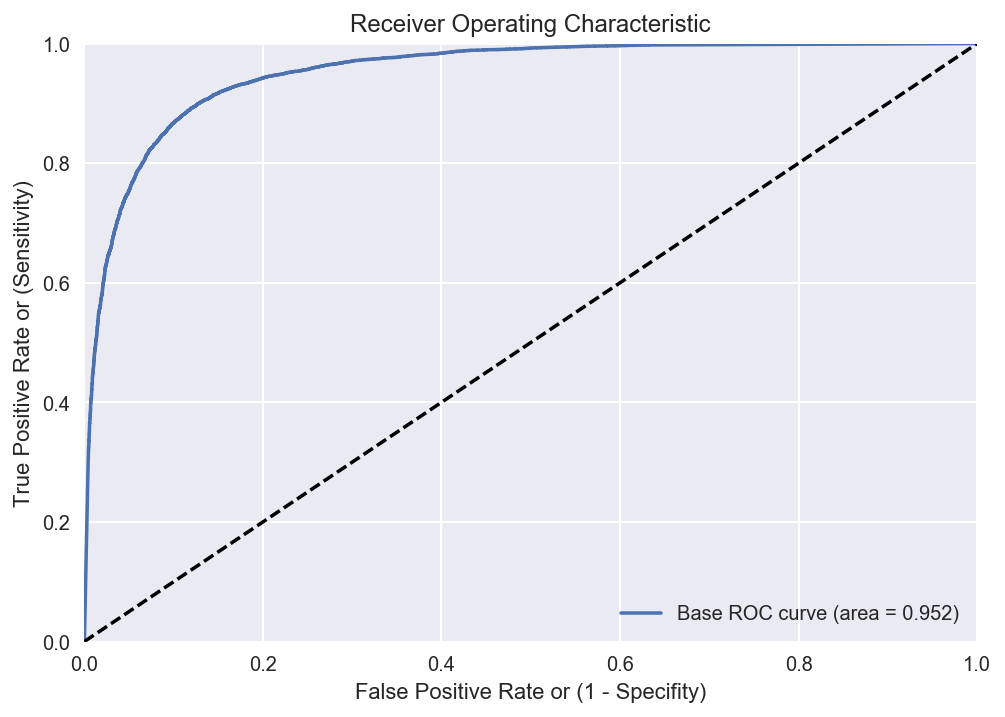

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

# Fit the model with the default paramter values
pipe.fit(X_train, y_train)

# Score with the test data
y_score = pipe.predict_proba(X_test)

auc_score_base = roc_auc_score(y_test, y_score[:,1])
print('Test AUC = {:.4f}'.format(auc_score_base))

# Compute false positive rate (fpr) and true positive rate (tpr)
fpr_base, tpr_base, _ = roc_curve(y_test,  y_score[:,1])

# Plot the ROC curve
plt.plot(fpr_base, tpr_base, label='Base ROC curve (area = %0.3f)' % auc_score_base)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter Tuning

In [8]:
from hyperopt import hp

# Parameter search space
space = {
    'vec__ngram_range': hp.choice('vec__ngram_range', [(1,1), (1,2), (1,3)]),  # One of (1,1), (1,2), or (1,3)
    'vec__min_df': 1+hp.randint('vec__min_df', 3),                             # Random integer in [1,3]
    'vec__max_df': hp.uniform('vec__max_df', 0.7, 1.0),                        # Uniform between 0.7 and 1
    'vec__sublinear_tf': hp.choice('vec__sublinear_tf', [True, False]),        # One of True or False
    'kbest__percentile': hp.uniform('kbest__percentile', 50, 100),             # Random number between 50 and 100
    'clf__l1_ratio': hp.uniform('clf__l1_ratio', 0.0, 1.0),                    # Random number between 0 and 1
    'clf__alpha': hp.loguniform('clf__alpha', -9*np.log(10), -4*np.log(10)),   # Log-uniform between 1e-9 and 1e-4
    'clf__n_iter': 20 + 5*hp.randint('clf__n_iter', 12)                        # Random integer in 20:5:80
}

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# The objective function that hyperopt will minimize
def objective(params):
    pipe.set_params(**params)
    shuffle = KFold(n_splits=10, shuffle=True)
    score = cross_val_score(pipe, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)
    return 1-score.mean()

In [10]:
from hyperopt import fmin, tpe, Trials

# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

In [11]:
from hyperopt import space_eval

# Get the values of the optimal parameters
best_params = space_eval(space, best)

# The optimal hyperparameter values I found after 1000 iterations. Uncomment to use these paramters.
# Gives a test AUC score of 0.9621
# best_params = {
#     'kbest__percentile': 58.810014948672134,
#     'clf__n_iter': 75,
#     'clf__l1_ratio': 0.0011725603957849658,
#     'clf__alpha': 4.8297400463260401e-05,
#     'vec__max_df': 0.77265658163292117,
#     'vec__min_df': 2,
#     'vec__ngram_range': (1, 3),
#     'vec__sublinear_tf': True
# }

# Fit the model with the optimal hyperparamters
pipe.set_params(**best_params)
pipe.fit(X_train, y_train);

# Score with the test data
y_score = pipe.predict_proba(X_test)
auc_score_tuned = roc_auc_score(y_test, y_score[:,1])

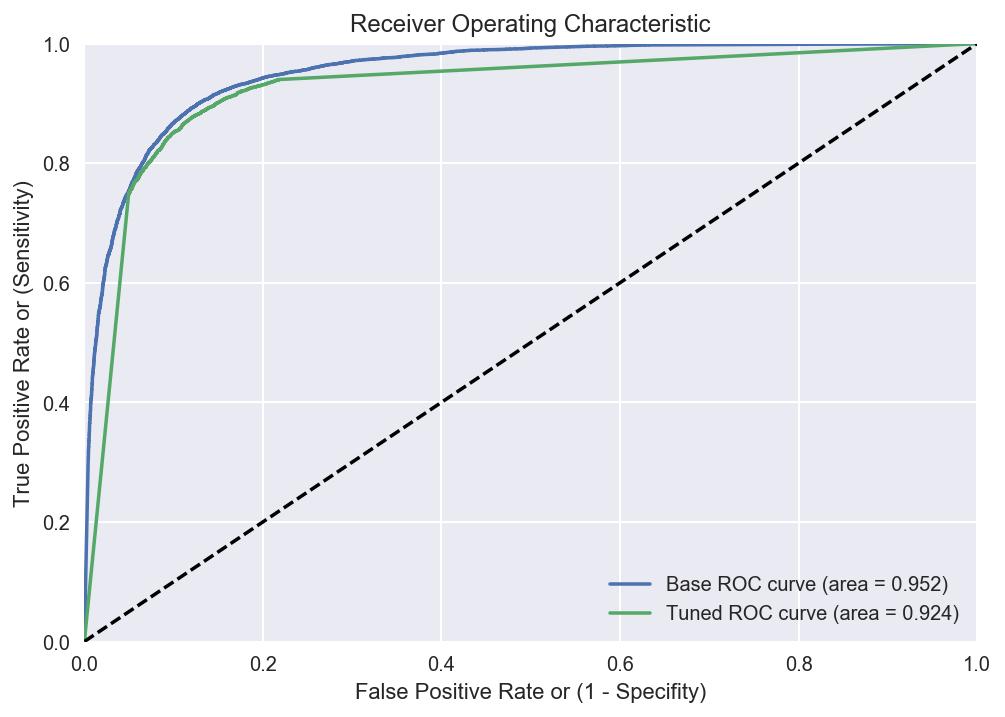

In [12]:
# Compute fpr, tpr, thresholds and roc auc
fpr_tuned, tpr_tuned, _ = roc_curve(y_test,  y_score[:,1])

# Plot ROC curve
plt.plot(fpr_base, tpr_base, label='Base ROC curve (area = %0.3f)' % auc_score_base)
plt.plot(fpr_tuned, tpr_tuned, label='Tuned ROC curve (area = %0.3f)' % auc_score_tuned)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Results

In [13]:
# Load the parameter values
param_df = pd.read_csv('parameter_values.csv')

# Add column for min/max n_gram
param_df['min_ngram'] = param_df['vec__ngram_range'].map(lambda row: int(row[1]))
param_df['max_ngram'] = param_df['vec__ngram_range'].map(lambda row: int(row[4]))

# Add column for loss
param_df['loss'] = param_df['scores_10_fold_cv'].map(lambda x: 1-x)

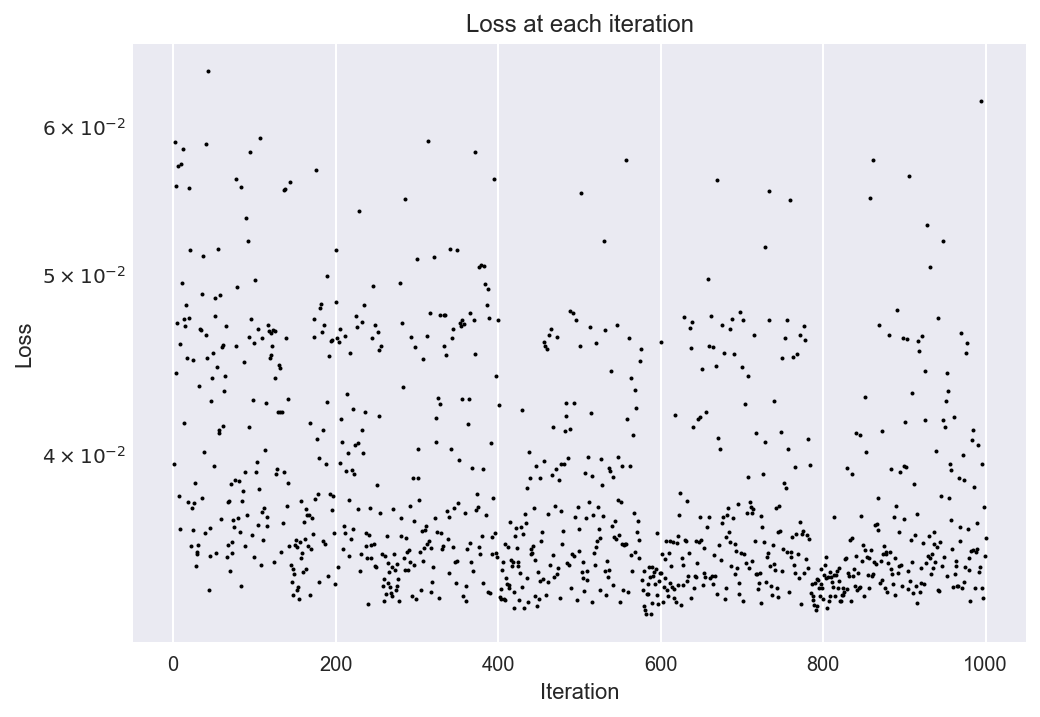

In [14]:
# Plot the loss at each iteration
plt.semilogy(np.arange(1,1001), param_df['loss'], 'ko', markersize=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss at each iteration')
plt.show();

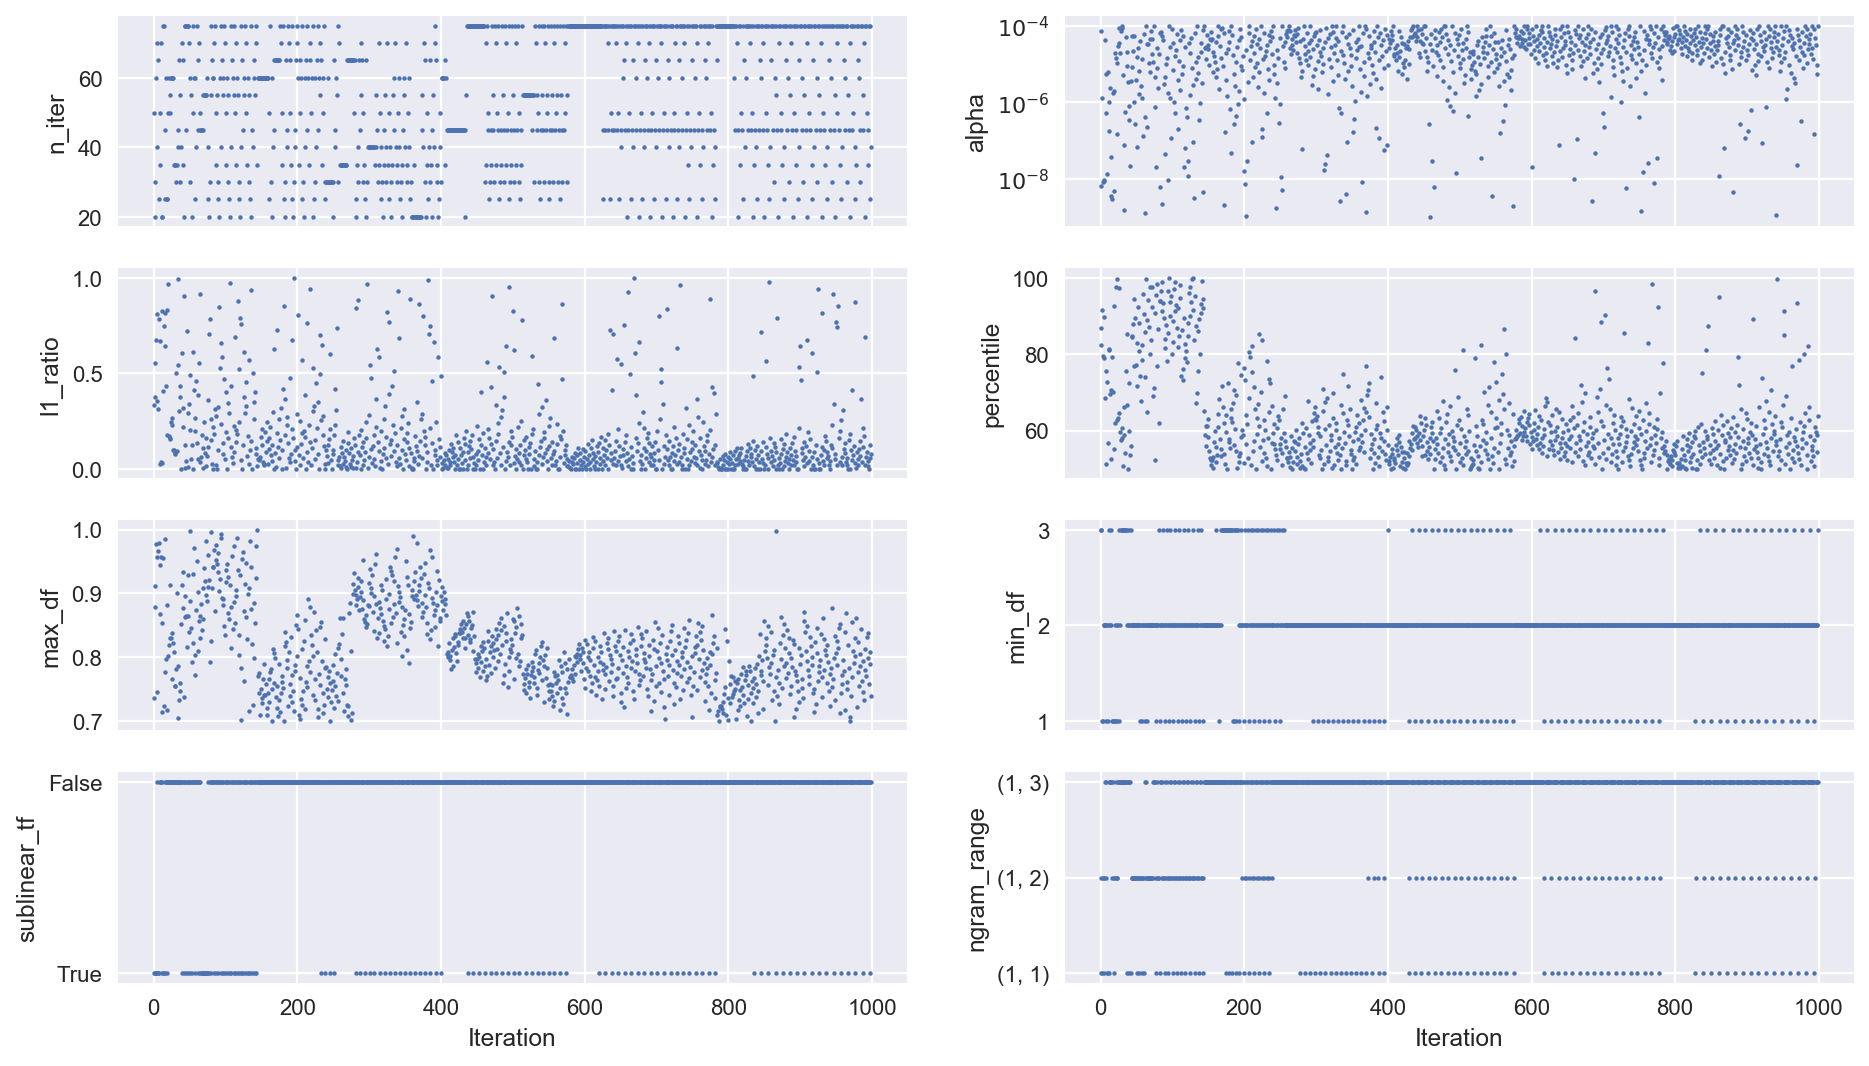

In [15]:
# Plot the hyperparameter values sampled at each iteration
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(4, 2, 1)
plt.plot(param_df.index.values, param_df['clf__n_iter'], 'o', markersize=2)
plt.ylabel('n_iter')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(4, 2, 2)
plt.semilogy(param_df.index.values, param_df['clf__alpha'], 'o', markersize=2)
plt.ylabel('alpha')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(4, 2, 3)
plt.plot(param_df.index.values, param_df['clf__l1_ratio'], 'o', markersize=2)
plt.ylabel('l1_ratio')
plt.setp(ax3.get_xticklabels(), visible=False)

# Look at all the kbest__percentile values sampled
ax4 = plt.subplot(4, 2, 4)
plt.plot(param_df.index.values, param_df['kbest__percentile'], 'o', markersize=2)
plt.ylabel('percentile')
plt.setp(ax4.get_xticklabels(), visible=False)

ax5 = plt.subplot(4, 2, 5)
plt.plot(param_df.index.values, param_df['vec__max_df'], 'o', markersize=2)
plt.ylabel('max_df')
plt.setp(ax5.get_xticklabels(), visible=False)

ax6 = plt.subplot(4, 2, 6)
plt.plot(param_df.index.values, param_df['vec__min_df'], 'o', markersize=2)
plt.ylabel('min_df')
plt.setp(ax6.get_xticklabels(), visible=False)

plt.subplot(4, 2, 7)
plt.plot(param_df.index.values, param_df['vec__sublinear_tf'], 'o', markersize=2)
plt.ylabel('sublinear_tf')
plt.xlabel('Iteration')
plt.yticks([0, 1], ['True', 'False'])

plt.subplot(4, 2, 8)
plt.plot(param_df.index.values, param_df['vec__ngram_range'].apply(lambda x: 0 if x == '(1, 1)' else 1 if x == '(1, 2)' else 2), 'o', markersize=2)
plt.ylabel('ngram_range')
plt.xlabel('Iteration')
plt.yticks([0, 1, 2], ['(1, 1)', '(1, 2)', '(1, 3)'])
plt.show()